# Task 2

The second task is about classifying handwritten digits. We will use the MNIST dataset for training and testing. The point of this task is to develop a multi-layer neural network for classification using mostly Numpy:
* Implement sigmoid and relu layers (with forward and backward pass) 
* Implement a softmax output layer 
* Implement a fully parameterizable neural network (number and types of layers, number  of units) 
* Implement an optimizer (e.g. SGD or Adam) and a stopping criterion of your choosing 
* Train your Neural Network using backpropagation.

Evaluate different neural network architectures and compare your different results. You can also compare with the results presented in http://yann.lecun.com/exdb/mnist/


### Loading the Data Set

We will use Pytorch's torchvision module to load the MNIST dataset.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import util

In [2]:
# Downloading MNIST
# Resources used:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# https://pytorch.org/docs/stable/torchvision/datasets.html#mnist

transform = transforms.Compose(
    [transforms.ToTensor()])

#Transet is the entire train set... each item is a 2-tuple, containing an tensor (numeric rep of image) and the target value (int)
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


Size of Train set is 60000
Size of Test set is 10000

Image depicts the target: 2


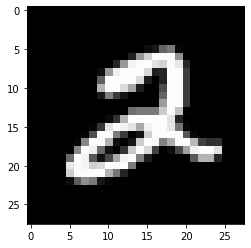

In [3]:
def display_image(image_pos=0, set=trainset):
    # First image's tensor accessed by set[0][0], its shape is 1, 28, 28
    # Notice set[0][1] is the target class of that image.. in this case, 5
    print(f"Image depicts the target: {set[image_pos][1]}")
    # imshow(imshow(torchvision.utils.make_grid(trainset[0][0])))
    imgplot = plt.imshow(set[image_pos][0].numpy().reshape((28, 28)), cmap='gray')


print(f"\nSize of Train set is {len(trainset)}")
print(f"Size of Test set is {len(testset)}\n")

display_image(image_pos=5, set=trainset)


## The Neural Network

Used Xavier's Random Distribution to initialize weights

https://medium.com/hackernoon/how-to-initialize-weights-in-a-neural-net-so-it-performs-well-3e9302d4490f

In [4]:
class Layer():
    def __init__(self, nodes_of_prev, nodes=784, activation="sigmoid", batch_size=1):
        self.nodes = nodes
        self.activation = activation
        self.nodes_of_prev = nodes_of_prev
        self.batch_size = batch_size
        #Additionally, each layer has:
        # - the weights going into it (nodes x nodes_of_prev)
        # - the biases of the layer (nodes x 1)
        # - z matrix, the dot product between the previous layer and the weights of this layer (nodes x batch_size)
        # - a matrix, the result of passing z into the activation function (nodes x batch_size)
        # - d matrix (nodes x batch_size)
        # - delta_accumulator matrix, (nodes x nodes_of_prev)
        self.weights = np.random.randn(self.nodes, self.nodes_of_prev) * np.sqrt(2/self.nodes)
        self.b = np.random.randn(self.nodes, 1) * np.sqrt(2/self.nodes)
        self.z = np.random.rand(self.nodes, self.batch_size)
        self.a = np.random.rand(self.nodes, self.batch_size)
        self.d = np.zeros(self.a.shape)
        self.delta_accumulator = np.zeros(self.weights.shape)
    
    def activate(self):
        if(self.activation == "sigmoid"):
            self.a = self.sigmoid(X=self.z)
        if(self.activation == "relu"):
            self.a = self.relu(X=self.z)
        if(self.activation == "softmax"):
            self.a = self.softmax(X=self.z)
    
    def derive(self, X):
        if(self.activation == "sigmoid"):
            return (self.sigmoid(X=X, diff=True))
        if(self.activation == "relu"):
            return (self.relu(X=X, diff=True))
        if(self.activation == "softmax"):
            return (self.softmax(X=X, diff=True))
    
    def sigmoid(self, X, diff=False):
        sigmoid_original = 1 / (1 + np.e**(-X))
        if (not diff):
            return sigmoid_original
        else:
            return sigmoid_original * (1 - sigmoid_original)
    
    def relu(self, X, diff=False):
        if(not diff):
            #Reference for replacing each value in np array:
            #https://stackoverflow.com/questions/19666626/replace-all-elements-of-python-numpy-array-that-are-greater-than-some-value
            X[X<=0] = 0
            return X
        else:
            X[X<=0] = 0
            X[X>0] = 1
            return X

    def softmax(self, X, diff=False):
        if (not diff):
            return (np.e ** X) / sum(np.e ** X)
        else:
            return (np.e ** X) / sum((np.e ** X)) * (1 - (np.e ** X) / sum((np.e ** X)))


In [5]:
class NN():
    def __init__(self, X, y, lr=0.001, reg_param=1, batch_size=0, early_stopping=False, lr_scaling=0, min_lr=0):
        self.X = X
        self.y = y
        self.n = self.X.shape[0] #Number of features (rows as features)
        self.m = self.X.shape[1] #Number of data points (samples as columns)
        self.layers = []
        self.loss_history = []
        self.epoch_loss_history = []
        self.a0 = None
        self.hx = None
        self.lr = lr
        self.reg_param = reg_param
        self.early_stopping = early_stopping
        self.lr_scaling = lr_scaling
        self.min_lr = min_lr
        self.batch_size = batch_size
        if self.batch_size <= 0:
            self.batch_size = self.m
    
    def add_layer(self, nodes=784, activation="sigmoid"):
        number_of_layers = len(self.layers)
        #If the layers array is empty, the layer to be added will have its nodes_of_prev equal n
        if number_of_layers == 0:
            layer_to_add = Layer(nodes_of_prev=self.n, nodes=nodes, activation=activation, batch_size=self.batch_size)
            self.layers.append(layer_to_add)
        #Else, the layer to be added will have its nodes_of_prev equal the nodes of the previous layer in self.layers
        else:
            prev_layer = self.layers[number_of_layers - 1]
            layer_to_add = Layer(nodes_of_prev=prev_layer.nodes, nodes=nodes, activation=activation, batch_size=self.batch_size)
            self.layers.append(layer_to_add)
    
    def forward_pass(self, X, test_batch_size=0):
        #Set the dimensions of each layer to test_batch_size if testing
        if test_batch_size > 0:
            for i in range(len(self.layers)):
                self.layers[i].batch_size = test_batch_size
        #Take batch X forward, accross layers
        for i in range(len(self.layers)):
            layer = self.layers[i]
            if i == 0:
                self.a0 = X
                layer.z = layer.weights.dot(self.a0) + layer.b
                layer.activate()
            else:
                prev_layer = self.layers[i - 1]
                layer.z = layer.weights.dot(prev_layer.a) + layer.b
                layer.activate()
                if i == (len(self.layers) - 1):
                    self.hx = layer.a
    
    def backward_pass(self, X, y):
        last_layer_index = len(self.layers) - 1
        #Starting from last layer, calculate all delta terms
        i = last_layer_index
        while i >= 0:
            layer = self.layers[i]
            #If this is the last layer
            if (i == last_layer_index):
                layer.d = self.hx - y
            else:
                next_layer = self.layers[i + 1]
                layer.d = (next_layer.weights.transpose().dot(next_layer.d)) * layer.derive(layer.z)
            #Decrement
            i -= 1
        #Starting from first layer, calcualte delta accumulators and update all weights accordingly
        for i in range(len(self.layers)):
            layer = self.layers[i]
            if (i == 0):
                self.a0 = X
                layer.delta_accumulator += layer.d.dot(self.a0.transpose())
                gradients = layer.delta_accumulator * (self.reg_param/self.m)
                layer.weights -= gradients * self.lr
            else:
                prev_layer = self.layers[i - 1]
                layer.delta_accumulator += layer.d.dot(prev_layer.a.transpose())
                gradients = layer.delta_accumulator * (self.reg_param/self.m)
                layer.weights -= gradients * self.lr

    def fit(self, epochs, calc_accuracy=None, loss_precision=7):
        number_of_batches = int(self.m / self.batch_size)
        loss = 0
        for e in range(epochs):
            print(f"Starting epoch {e + 1}/{epochs}. ", end="")
            print("Processing: ", end="")
            for b in range(number_of_batches):
                if(number_of_batches%(b+1) == 0):
                    print(f"*", end="")
                start = b * self.batch_size
                end = (b + 1) * self.batch_size
                Xi = self.X[:, start:end]
                yi = self.y[:, start:end]
                self.forward_pass(Xi)
                self.backward_pass(Xi, yi)
                loss = self.calc_loss(self.hx, yi)
                self.loss_history.append(loss)
            print(f"\nLoss is {np.around(loss, loss_precision)}. ", end="")
            if not calc_accuracy == None:
                X_test = calc_accuracy["X_test"]
                y_test = calc_accuracy["y_test"]
                accuracy = self.score(X_test, y_test)
                print(f"Accuracy is {accuracy}")
            print(f"\n")
            self.epoch_loss_history.append(loss)
            if (e > 0 and (self.early_stopping or self.lr_scaling > 0)):
                #If current loss is less than previous one...
                if loss > self.epoch_loss_history[e - 1]:
                    #If lr scaling is set...
                    if(self.lr_scaling > 0):
                        print(f"Beginning to diverge... scaling learning rate by from {self.lr}, by {self.lr_scaling}, to {self.lr * self.lr_scaling}")
                        #If a minimum lr is set
                        if self.min_lr > 0:
                            self.lr = max((self.lr_scaling * self.lr), self.min_lr)
                        else:
                            self.lr *= self.lr_scaling
                    #If early stopping is set
                    if(self.early_stopping):
                        if(self.lr_scaling <= 0 or self.lr == self.min_lr):
                            print(f"Beginning to diverge... stopping early on epoch {e}")
                            break

    def calc_loss(self, hx, y):
        loss = (sum(sum((y * np.log(hx)) + ((1 - y) * np.log(1 - hx)))) / self.m) * -1
        return loss
    
    def plot_loss(self):
        history = self.epoch_loss_history
        plt.ylim((min(history)), (max(history)))
        plt.title("Loss Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.plot(list(range(len(history))), history)
        plt.show()
    
    def score(self, X_test, y_test):
        predictions = self.predict(X_test)
        correct_answers = 0
        total_tests = len(predictions[0])
        for i in range(total_tests):
            prediction = util.decode(util.encode_probabilities(predictions[:, i]))
            correct = util.decode(y_test[:, i])
            if prediction == correct:
                correct_answers += 1
        accuracy = correct_answers / total_tests
        return accuracy
    
    def predict(self, X_test):
        test_batch_size = len(X_test)
        self.forward_pass(X_test, test_batch_size=test_batch_size)
        return self.hx


In [6]:
#Split into features and target
features, target = util.preprocess(X=trainset.data, y=trainset.targets)

In [7]:
features_short, target_short = util.shorten(features, target, start=0, end=10000)

In [8]:
X_test, y_test = util.preprocess(X=testset.data, y=testset.targets)

In [11]:
nn = NN(X=features_short, y=target_short, lr=1e-5, reg_param=1, batch_size=64, lr_scaling=0.8)
nn.add_layer(nodes=100, activation="sigmoid")
nn.add_layer(nodes=60, activation="relu")
nn.add_layer(nodes=50, activation="sigmoid")
nn.add_layer(nodes=10, activation="softmax")

In [12]:
%%time
epochs_to_do = 1000
nn.fit(epochs=epochs_to_do, calc_accuracy={"X_test": X_test, "y_test": y_test})

s 0.0101294. Accuracy is 0.6823


Starting epoch 782/1000. Processing: ************
Loss is 0.0101174. Accuracy is 0.6834


Starting epoch 783/1000. Processing: ************
Loss is 0.0101062. Accuracy is 0.6846


Starting epoch 784/1000. Processing: ************
Loss is 0.0100954. Accuracy is 0.6855


Starting epoch 785/1000. Processing: ************
Loss is 0.0100853. Accuracy is 0.6864


Starting epoch 786/1000. Processing: ************
Loss is 0.0100751. Accuracy is 0.6874


Starting epoch 787/1000. Processing: ************
Loss is 0.0100649. Accuracy is 0.6884


Starting epoch 788/1000. Processing: ************
Loss is 0.0100542. Accuracy is 0.6894


Starting epoch 789/1000. Processing: ************
Loss is 0.0100425. Accuracy is 0.6905


Starting epoch 790/1000. Processing: ************
Loss is 0.01003. Accuracy is 0.6912


Starting epoch 791/1000. Processing: ************
Loss is 0.0100165. Accuracy is 0.6924


Starting epoch 792/1000. Processing: ************
Loss is 0.0100014.

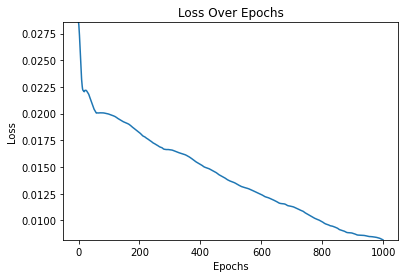

In [13]:
nn.plot_loss()

In [15]:
accuracy = nn.score(X_test, y_test)
print(accuracy)

0.7399
